In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import general python libraries
import numpy as np
from numpy.testing import assert_allclose
import matplotlib.pyplot as plt
from scipy.special import gammainc, gammaincc, gamma
from scipy.integrate import quad

# Import libraries specific to materials science
import ase
from ase import Atoms
import MDAnalysis as mda
from MDAnalysis.analysis.distances import distance_array, self_distance_array

# Import from pyLODE
from pylode.lib.projection_coeffs import DensityProjectionCalculator

# Density function and its Fourier Transform

There are some tests that need to be performed regarding the density function. Most importantly, we verify that the Fourier transform is indeed correct including the global prefactor.

In [3]:
def gammainc_upper_numerical(n, zz):
    """
    Implement upper incomplete Gamma function
    """
    yy = np.zeros_like(zz)
    integrand = lambda x: x**(n-1) * np.exp(-x)
    for iz, z in enumerate(zz):
        yy[iz] = quad(integrand, z, np.inf)[0]
    return yy

In [4]:
def density_realspace(p, x, smearing):
    if p==0:
        return np.exp(-0.5 * x**2 / smearing**2)
    else:
        return gammainc(p/2, 0.5*(x/smearing)**2) / x**p

def density_fourierspace(p, k, smearing):
    peff = 3-p
    prefac = np.pi**1.5 * 2**peff / gamma(p/2)
    return prefac * gammainc_upper_numerical(peff/2, 0.5*(k*smearing)**2) / k**peff

In [5]:
def gaussian_real(x, sigma):
    return np.exp(-0.5 * x**2 / sigma**2)

def gaussian_fourier(k, sigma):
    return (2*np.pi)**1.5 * np.exp(-0.5 * k**2 * sigma**2)

## Test the realspace density

In these plots, we illustrate the behavior of the smeared $1/r^p$ densities used in LODE. The densities are compared to Gaussian as well as pure $1/r^p$ densities, partly to verify that these indeed have the correct asymptotic behavior. As a further analytical test, we analytically compute the value of the smeared density at $x=0$ and compare this with the value obtained numerically by taking the limit $x \rightarrow 0$.

Exponent p = 1
Deviation at x=1e-08 from analytical result at x=0 is 4.440892098500626e-16
Rel. difference to pure 1/r^p at r=2*smearing = 0.04550026389635853
Rel. difference to pure 1/r^p at r=3*smearing = 0.002699796063260207
Rel. difference to pure 1/r^p at r=4*smearing = 6.334248366623996e-05

Exponent p = 2
Deviation at x=1e-08 from analytical result at x=0 is 8.881784197001252e-16
Rel. difference to pure 1/r^p at r=2*smearing = 0.1353352832366127
Rel. difference to pure 1/r^p at r=3*smearing = 0.011108996538242155
Rel. difference to pure 1/r^p at r=4*smearing = 0.00033546262790251635

Exponent p = 3
Deviation at x=1e-08 from analytical result at x=0 is 1.6653345369377348e-16
Rel. difference to pure 1/r^p at r=2*smearing = 0.26146412994911117
Rel. difference to pure 1/r^p at r=3*smearing = 0.0292908865348881
Rel. difference to pure 1/r^p at r=4*smearing = 0.0011339842897852837

Exponent p = 4
Deviation at x=1e-08 from analytical result at x=0 is 4.163336342344337e-16
Rel. differen

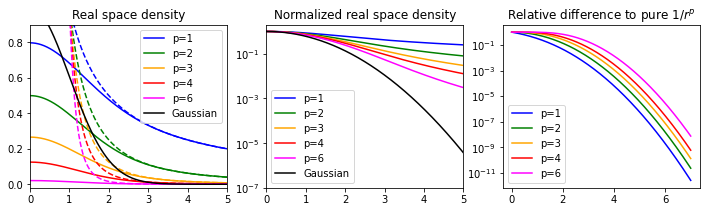

In [6]:
# Real space density
Nplot = 1000
xx = np.linspace(1e-8, 7, Nplot)
smearing = 1.
fig, ax = plt.subplots(ncols = 3, figsize=(12,3))
colors = ['blue', 'green', 'orange', 'red', 'magenta']
for i, p in enumerate([1, 2, 3, 4, 6]):    
    yy_pure = 1/xx**p
    yy_smeared = density_realspace(p, xx, smearing)
    ax[0].plot(xx, yy_smeared, color=colors[i], label=f'p={p}')
    ax[0].plot(xx, yy_pure, '--', color=colors[i])
    
    # Make sure that the height at zero is correct
    height_at_zero = 1. / (2*smearing**2)**(p/2) / gamma(p/2+1)
    ax[1].plot(xx, yy_smeared / height_at_zero, color=colors[i], label=f'p={p}')
    print(f'Exponent p = {p}')
    print(f'Deviation at x={min(xx)} from analytical result at x=0 is {abs(yy_smeared[0]-height_at_zero)}')
    
    # Check that the far field behavior matches the pure 1/r^p
    diff = yy_pure - yy_smeared
    ax[2].semilogy(xx, diff / yy_pure, color=colors[i], label=f'p={p}')
    diff_at_two_sigma = 1/(2*smearing)**p - density_realspace(p, 2*smearing, smearing)
    diff_at_two_sigma *= (2*smearing)**p
    diff_at_three_sigma = 1/(3*smearing)**p - density_realspace(p, 3*smearing, smearing)
    diff_at_three_sigma *= (3*smearing)**p
    diff_at_four_sigma = 1/(4*smearing)**p - density_realspace(p, 4*smearing, smearing)
    diff_at_four_sigma *= (4*smearing)**p
    print(f'Rel. difference to pure 1/r^p at r=2*smearing = {diff_at_two_sigma}')
    print(f'Rel. difference to pure 1/r^p at r=3*smearing = {diff_at_three_sigma}')
    print(f'Rel. difference to pure 1/r^p at r=4*smearing = {diff_at_four_sigma}')
    print()

# Add Gaussian for reference
yy_smeared = gaussian_real(xx, smearing)
ax[0].plot(xx, yy_smeared, color='black', label=f'Gaussian')
ax[1].plot(xx, yy_smeared, color='black', label=f'Gaussian')

# Add labels
ax[0].set_ylim(-0.02, 0.9)
ax[0].set_title('Real space density')
ax[0].legend(loc='upper right')
ax[0].set_xlim(0,5)

ax[1].set_title('Normalized real space density')
ax[1].legend(loc='lower left')
ax[1].set_xlim(0,5)
ax[1].set_ylim(1e-7,2)
ax[1].set_yscale('log')

ax[2].set_title(r'Relative difference to pure $1/r^p$')
ax[2].legend(loc='lower left')

## Test the Fourier Transform of the Real Space Density

We plot the Fourier transformed versions of the smeared $1/r^p$ densities. The first plot compares the behavior to a Fourier transformed Gaussian density, which illustrates how quickly these smeared densities decay. Furthermore, to check that the Fourier transform has been computed correctly, we explicitly calculate the Fourier transform of the real space densities using numerical integration for comparison with the analytical expression. Note that this can only be done for exponents $p > 3$, since the involved integrals would otherwise diverge. 

<ipython-input-7-e4987e4614c9>:27: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  fhat_numerical[ik] = 4 * np.pi*quad(integrand, 0, np.inf, limit=100, epsabs=abstol)[0]


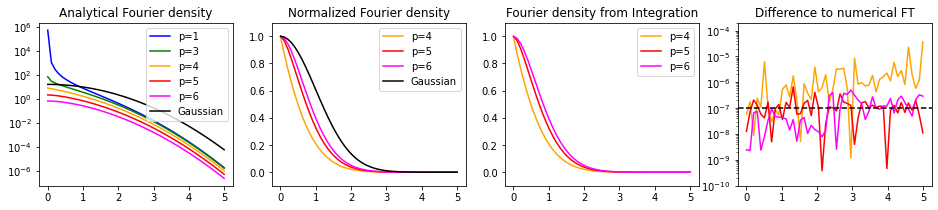

In [7]:
# Reciprocal space density
Nplot = 50
kk = np.linspace(5e-3, 5, Nplot)
abstol = 1e-7

# Start generating the plots
fig, ax = plt.subplots(ncols = 4, figsize=(16,3))
for i, p in enumerate([1, 3, 4, 5, 6]):    
    # Plot the Fourier transformed density
    yy_smeared = density_fourierspace(p, kk, smearing)
    ax[0].plot(kk, yy_smeared, color=colors[i], label=f'p={p}')
    
    # For long range potentials, the Fourier transform at k=0 diverges
    if p <= 3:
        continue
    
    # Check that the height at zero is correct
    peff = 3-p
    prefac = np.pi**1.5 * 2**peff / gamma(p/2) # global prefactor appearing in Fourier transformed density
    height_at_zero = prefac * 2**((p-1)/2) / (-peff) * smearing**(-peff)
    ax[1].plot(kk, yy_smeared / height_at_zero, color=colors[i], label=f'p={p}')
    
    # Compare with numerical results
    fhat_numerical = np.zeros_like(kk)
    for ik, k in enumerate(kk):
        integrand = lambda x: density_realspace(p, x, smearing) * np.sinc(k * x / np.pi) * x**2
        fhat_numerical[ik] = 4 * np.pi*quad(integrand, 0, np.inf, limit=100, epsabs=abstol)[0]
    ax[2].plot(kk, fhat_numerical / height_at_zero, color=colors[i], label=f'p={p}')

    # Plot difference between explicit Fourier transform and formula
    ax[3].semilogy(kk, np.abs(fhat_numerical - yy_smeared), color=colors[i], label=f'p={p}')
    
    
# Add Gaussian for reference
yy_smeared = gaussian_fourier(kk, smearing)
ax[0].plot(kk, yy_smeared, color='black', label=f'Gaussian')
ax[1].plot(kk, yy_smeared / (2*np.pi*smearing**2)**1.5, color='black', label=f'Gaussian')

# Add labels
ax[0].set_title('Analytical Fourier density')
ax[0].legend(loc='upper right')
#ax[0].set_ylim(-0.1,2)
ax[0].set_yscale('log')

ax[1].set_title('Normalized Fourier density')
ax[1].legend(loc='upper right')
ax[1].set_ylim(-0.1, 1.1)

ax[2].set_title('Fourier density from Integration')
ax[2].legend(loc='upper right')
ax[2].set_ylim(-0.1,1.1)

ax[3].set_title('Difference to numerical FT')
ax[3].set_ylim(1e-10, 2e-4)
ax[3].axhline(y = abstol, color = 'k', linestyle = '--')

## Check consistency on lattice sums

In [8]:
def lattice_summation(f, L, nneigh=3, avoid_center=True):
    total_sum = 0
    num = (2*nneigh + 1)**3
    if avoid_center:
        num -= 1
    radii = np.zeros((num,))
    idx = 0
    for ix in range(-nneigh, nneigh+1):
        for iy in range(-nneigh, nneigh+1):
            for iz in range(-nneigh, nneigh+1):
                if ix==0 and iy==0 and iz==0 and avoid_center:
                    continue
                rad = np.sqrt(ix**2+iy**2+iz**2)*L
                #radii.append(rad)
                radii[idx] = rad
                idx += 1
    
    radii_sorted = np.sort(radii)
    funcvals = f(radii)
    
    total_sum = np.sum(funcvals)
        
    return total_sum

### Lattice sums using a Gaussian potential

Check that the lattice summations are working correctly by verifying the Poisson summation formula which relates real and reciprocal space sums for simple Gaussian densities.

Text(0.5, 1.0, 'Relative difference')

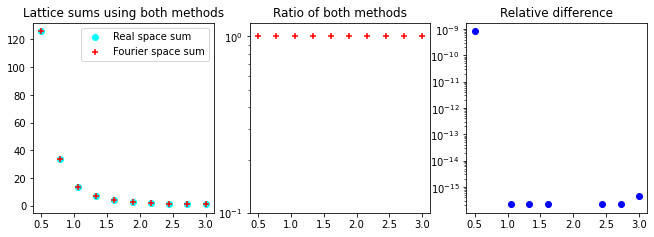

In [9]:
# Define inputs
sigma = 1.0
f_real = lambda x: gaussian_real(x, sigma)
f_fourier = lambda k: gaussian_fourier(k, sigma)
f0_real = f_real(0)
f0_fourier = f_fourier(0)

Ls = np.linspace(0.5,3,10)

sums_real = np.zeros_like(Ls)
sums_fourier = np.zeros_like(Ls)

# Evaluate the lattice sums using both methods
for iL, L in enumerate(Ls):
    sums_real[iL] = lattice_summation(f_real, L, nneigh=12)
    sums_fourier[iL] = lattice_summation(f_fourier, 2*np.pi/L, nneigh=12) / L**3
sums_real += f0_real
sums_fourier += f0_fourier / Ls**3

fig, ax = plt.subplots(figsize=(11,3.5), ncols = 3)
ax[0].scatter(Ls, sums_real, c='cyan', marker='o', label='Real space sum')
ax[0].scatter(Ls, sums_fourier, c='r', marker='+', label='Fourier space sum')
ax[0].legend(loc='upper right')
ax[0].set_title('Lattice sums using both methods')

ratios = sums_fourier / sums_real 
ax[1].scatter(Ls, ratios, color='red', marker='+')
ax[1].set_title('Ratio of both methods')
ax[1].set_ylim(0.1,1.2)
ax[1].set_yscale('log')

ax[2].semilogy(Ls, np.abs(ratios - 1.), 'bo')
ax[2].set_title('Relative difference')

### Lattice sums using the smeared IPL potentials

Check the behavior of the lattice sums for the smeared $1/r^p$ potentials.

Text(0.5, 1.0, 'Relative difference')

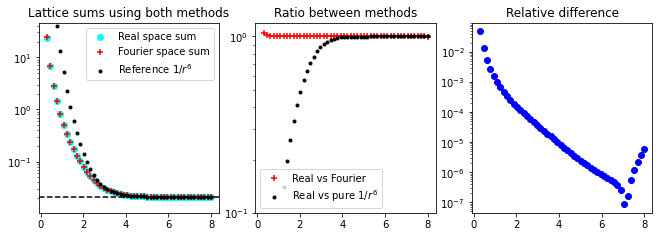

In [10]:
# Define inputs
smearing = 1.0
p = 6
f_real = lambda x: density_realspace(p, x, smearing)
f_fourier = lambda k: density_fourierspace(p, k, smearing)
f_ref = lambda x: 1/x**p

# Compensate for the lack of the center atom contribution
f0_real = 1 / (2*smearing**2)**(p/2) / gamma(p/2+1)
peff = 3-p
prefac = np.pi**1.5 * 2**peff / gamma(p/2) # global prefactor appearing in Fourier transformed density
f0_fourier = prefac * 2**((p-1)/2) / (-peff) * smearing**(-peff)
Ls = np.linspace(0.3,8,50)
L0 = 1.

# Evaluate the lattice sums using both methods
sums_real = np.zeros_like(Ls)
sums_fourier = np.zeros_like(Ls)
sums_ref = np.zeros_like(Ls)
for iL, L in enumerate(Ls):
    sums_real[iL] = lattice_summation(f_real, L, nneigh=14)
    sums_fourier[iL] = lattice_summation(f_fourier, 2*np.pi/L, nneigh=5) /L**3
    sums_ref[iL] = lattice_summation(f_ref, L, nneigh=12)
sums_real += f0_real
sums_fourier += f0_fourier / Ls**3

fig, ax = plt.subplots(figsize=(11,3.5), ncols = 3)
ax[0].scatter(Ls, sums_real, c='cyan', marker='o', label='Real space sum')
ax[0].scatter(Ls, sums_fourier, c='r', marker='+', label='Fourier space sum')
ax[0].scatter(Ls, sums_ref + f0_real, c='k', marker='.', label=r'Reference $1/r^{0}$'.format(p))
ax[0].legend(loc='upper right')
ax[0].set_yscale('log')
ax[0].set_title('Lattice sums using both methods')
ax[0].set_ylim(min(sums_fourier)/2, max(sums_real)*2)
ax[0].axhline(y = f0_real, color = 'k', linestyle = '--')

ratios = sums_fourier / sums_real
ratios_ref = (sums_real - f0_real) / sums_ref
ax[1].scatter(Ls, ratios, c='r', marker='+', label='Real vs Fourier')
ax[1].scatter(Ls, ratios_ref, c='k', marker='.', label=r'Real vs pure $1/r^{0}$'.format(p))
ax[1].set_title('Ratio between methods')
ax[1].set_ylim(0.1,1.2)
ax[1].set_yscale('log')
ax[1].legend(loc='lower left')

ax[2].semilogy(Ls, np.abs(ratios - 1.), 'bo')
ax[2].set_title('Relative difference')

-2.981039653234141
Slope =  -5.999999998882228


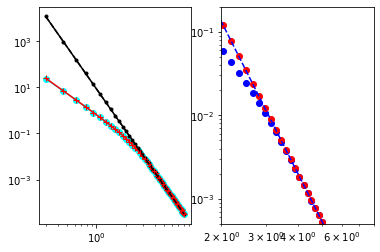

In [11]:
linear_fit_coeffs = np.polyfit(np.log(Ls[-3:]), np.log(sums_real[-3:] - f0_real), 1)
linear_fit_coeffs_smallL = np.polyfit(np.log(Ls[:5]), np.log(sums_real[:5] - f0_real), 1)
print(linear_fit_coeffs_smallL[0])
linear_fit_coeffs_ref = np.polyfit(np.log(Ls), np.log(sums_ref), 1)

Ls_continuous = np.linspace(min(Ls), max(Ls), 100)
potentials_real_fitted = Ls_continuous**linear_fit_coeffs[0] * np.exp(linear_fit_coeffs[1])

# Big picture
fig, ax = plt.subplots(ncols=2)
ax[0].loglog(Ls, sums_real  - f0_real, c='cyan', marker='o')
ax[0].loglog(Ls, sums_ref, c='k', marker='.')
ax[0].loglog(Ls, sums_fourier - f0_real, c='r', marker='+')
ax[0].loglog(Ls_continuous, potentials_real_fitted, 'k--')

ax[1].loglog(Ls, sums_real  - f0_real, 'bo')
ax[1].loglog(Ls, sums_ref, 'ro')
ax[1].loglog(Ls_continuous, potentials_real_fitted, 'b--')

ax[1].set_ylim(5e-4,2e-1)
ax[1].set_xlim(2,max(Ls))
print('Slope = ', linear_fit_coeffs[0])

## Convergence of Fourier space sum with the number of neighbors

Rel. errors for (iL, L) =  0 1.0
[2.89700843e-16 1.44850422e-16 2.89700843e-16 1.44850422e-16
 2.89700843e-16 2.89700843e-16 2.89700843e-16 2.89700843e-16
 2.89700843e-16 2.89700843e-16]
Rel. errors for (iL, L) =  1 1.6363636363636362
[7.52773831e-11 0.00000000e+00 1.54217746e-16 3.08435492e-16
 0.00000000e+00 0.00000000e+00 3.08435492e-16 3.08435492e-16
 0.00000000e+00 1.54217746e-16]
Rel. errors for (iL, L) =  2 2.2727272727272725
[3.72210036e-06 9.07335792e-15 1.14852632e-16 0.00000000e+00
 1.14852632e-16 1.14852632e-16 0.00000000e+00 1.14852632e-16
 1.14852632e-16 1.14852632e-16]
Rel. errors for (iL, L) =  3 2.909090909090909
[4.12955314e-04 1.81581326e-09 0.00000000e+00 0.00000000e+00
 1.45143582e-16 2.90287163e-16 0.00000000e+00 1.45143582e-16
 2.90287163e-16 0.00000000e+00]
Rel. errors for (iL, L) =  4 3.5454545454545454
[5.21716526e-03 1.09786198e-06 1.12940373e-11 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.70298668e-16 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
Rel. e

Text(0, 0.5, 'Converged energies')

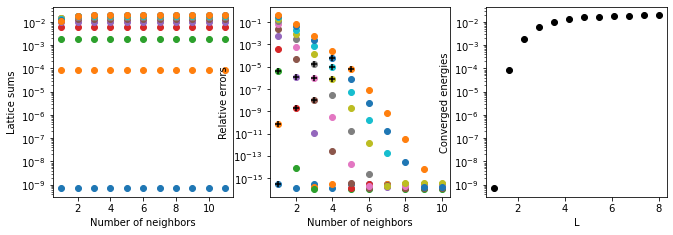

In [12]:
smearing = 1.0
p = 6
f_real = lambda x: density_realspace(p, x, smearing)
f_fourier = lambda k: density_fourierspace(p, k, smearing)

Ls_test = np.linspace(1, 8, 12)
nneighs = 1 + np.arange(11)

# Make plots
fig, ax = plt.subplots(figsize=(11, 3.5), ncols = 3)
converged_energies = np.zeros_like(Ls_test)
for iL, L in enumerate(Ls_test):
    print('Rel. errors for (iL, L) = ', iL, L)
    energies = []
    for ineigh, nneigh in enumerate(nneighs):
        total_energy = lattice_summation(f_fourier, 2*np.pi/L, nneigh=nneigh, avoid_center=True) / L**3
        energies.append(total_energy)
    
    energies = np.array(energies)
    deltas = np.abs(energies[-1] - energies[:-1])
    print(deltas / energies[-1])
    
    stepsize = 2*np.pi / L
    kmax_lode = round(1.2 * np.pi / stepsize)
    
    ax[0].scatter(nneighs, energies, label=f'L={L:4.2e}')
    ax[1].scatter(nneighs[:-1], deltas/energies[-1], label=f'L={L:4.2e}')
    ax[1].scatter(nneighs[kmax_lode-1], deltas[kmax_lode-1]/energies[-1], c='k', marker='+')
    converged_energies[iL] = energies[-1]

ax[0].set_yscale('log')
ax[0].set_xlabel('Number of neighbors')
ax[0].set_ylabel('Lattice sums')
#ax[0].legend(loc='upper right')

ax[1].set_xlabel('Number of neighbors')
ax[1].set_ylabel('Relative errors')
ax[1].set_yscale('log')

converged_energies = np.array(converged_energies)
ax[2].scatter(Ls_test, converged_energies, c='k')
ax[2].set_yscale('log')
ax[2].set_xlabel('L')
ax[2].set_ylabel('Converged energies')

<ipython-input-13-b937728af529>:39: RuntimeWarning: divide by zero encountered in true_divide
  ratios_ref = (sums_real - f0_real) / sums_ref


Text(0.5, 1.0, 'Relative difference')

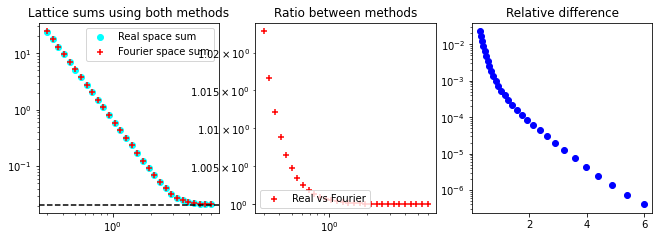

In [13]:
# Define inputs
smearing = 1.0
p = 6
f_real = lambda x: density_realspace(p, x, smearing)
f_fourier = lambda k: density_fourierspace(p, k, smearing)
f_ref = lambda x: 1/x**p

# Compensate for the lack of the center atom contribution
f0_real = 1 / (2*smearing**2)**(p/2) / gamma(p/2+1)
peff = 3-p
prefac = np.pi**1.5 * 2**peff / gamma(p/2) # global prefactor appearing in Fourier transformed density
f0_fourier = prefac * 2**((p-1)/2) / (-peff) * smearing**(-peff)
Ls = np.geomspace(0.3, 6, 30)
L0 = 1.

# Evaluate the lattice sums using both methods
sums_real = np.zeros_like(Ls)
sums_fourier = np.zeros_like(Ls)
sums_ref = np.zeros_like(Ls)
for iL, L in enumerate(Ls):
    sums_real[iL] = lattice_summation(f_real, L, nneigh=18)
    sums_fourier[iL] = lattice_summation(f_fourier, 2*np.pi/L, nneigh=12) /L**3
    #sums_ref[iL] = lattice_summation(f_ref, L, nneigh=12)
sums_real += f0_real
sums_fourier += f0_fourier / Ls**3

fig, ax = plt.subplots(figsize=(11,3.5), ncols = 3)
ax[0].scatter(Ls, sums_real, c='cyan', marker='o', label='Real space sum')
ax[0].scatter(Ls, sums_fourier, c='r', marker='+', label='Fourier space sum')
#ax[0].scatter(Ls, sums_ref + f0_real, c='k', marker='.', label='Reference')
ax[0].legend(loc='upper right')
ax[0].set_yscale('log')
ax[0].set_title('Lattice sums using both methods')
#ax[0].set_ylim(min(sums_fourier)/2, max(sums_fourier)*2)
ax[0].axhline(y = f0_real, color = 'k', linestyle = '--')
ax[0].set_xscale('log')

ratios = sums_fourier / sums_real
ratios_ref = (sums_real - f0_real) / sums_ref
ax[1].scatter(Ls, ratios, c='r', marker='+', label='Real vs Fourier')
#ax[1].scatter(Ls, ratios_ref, c='k', marker='.', label=r'Real vs pure $1/r^p$')
ax[1].set_title('Ratio between methods')
#ax[1].set_ylim(0.1,1.2)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(loc='lower left')

ax[2].semilogy(Ls, np.abs(ratios - 1.), 'bo')
ax[2].set_title('Relative difference')

# Define and test function to compute van der Waals interactions

### Define an auxilary function to compute the van der Waals energy of a structure

In [14]:
def van_der_waals_pure(r):
    return 1./r**6

def periodic_energy(positions,
                    interaction_func,
                    box,
                    nneigh=5,
                    func_params=None):
    """Calculates the 3D periodic energy of an atomic system
    INPUTS:
    positions: numpy.ndarray of shape (Natoms, 3)
    interaction_func: Interaction between atoms
    box: Dimensions of a rectangular box (in 3 lengths, 3 angles convention to use MDAnalysis)
    nneigh: number of periodic images in each direction
    """
    if func_params is None:
        func_params = {}

    # First, compute the interaction energy between all atoms
    # within the original cell without taking into account periodic images
    distances = self_distance_array(positions, box)
    total_energy = np.sum(interaction_func(distances, **func_params))

    # Generate the positions of all desired periodic images
    a_x, a_y, a_z = mda.lib.mdamath.triclinic_vectors(box)
    positions_replica = []
    for i in range(-nneigh, nneigh+1):
        for j in range(-nneigh, nneigh+1):
            for k in range(-nneigh, nneigh+1):
                if (i == j == k == 0):  # exclude origin
                    continue
                positions_replica.append(positions + i*a_x + j*a_y + k*a_z)
    
    positions_replica = np.array(positions_replica)
    # reshape to be a (n , 3) array
    positions_replica = positions_replica.reshape(
        np.prod(positions_replica.shape[:2]), 3)

    # Add the contributions arising from interactions between the atoms in
    # the original cell (stored in positions) and the periodic images excluding
    # those from the original cell (stored in positions_replica)
    # This avoids double counting the pairs within the original cell
    distances_replica = distance_array(positions, positions_replica).flatten()

    total_energy += np.sum(interaction_func(distances_replica,
                                            **func_params))

    return total_energy

### Example 1: Simple cubic cell with single atom per unit cell

Examine convergence of lattice sum with respect to the number of neighbors included in the sum.

In [15]:
# Example: Use the above function to compute the energy of some simple crystals
# whose atoms interact via a pure van der Waals potential
positions = np.array([[0, 0, 0]])
dist = 4.
box = [dist, dist, dist, 90, 90, 90]

# Test the convergence of the energy with the number of periodic neighbors
cubic_energy = []
for i in range(1,12):
    total_energy = periodic_energy(positions=positions,
                                   interaction_func=van_der_waals_pure,
                                   box=box,
                                   nneigh=i)
    cubic_energy.append(total_energy)
cubic_energy = np.array(cubic_energy)

In [16]:
# Compare with analytical expression for one periodic image layer
energy_ref = 0.
energy_ref += 6 / dist**6 + 12 / (np.sqrt(2)*dist)**6 + 8 / (np.sqrt(3)*dist)**6
assert((cubic_energy[0] - energy_ref) < 1e-15)

Relative error at final point:  6.115249229321818e-05


Text(0, 0.5, 'Total energy')

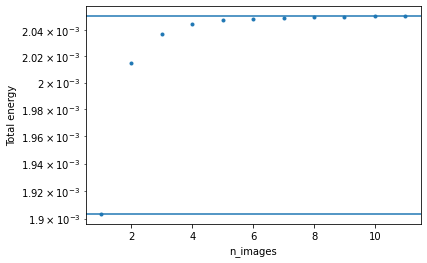

In [17]:
relerr = (cubic_energy[-1] - cubic_energy[-2])/cubic_energy[-1]
print('Relative error at final point: ', relerr)
plt.yscale("log")
plt.plot(1+np.arange(len(cubic_energy)),
         cubic_energy, ".")
plt.axhline(cubic_energy[-1])
plt.axhline(energy_ref)
plt.xlabel("n_images")
plt.ylabel("Total energy")

### Example 2: Diatomic unit cell

In [18]:
# Example: Use the above function to compute the energy of some simple crystals
# whose atoms interact via a pure van der Waals potential
positions = np.array([[0, 0, 0], [0.5, 0.5, 0.5]])
dist = 4.
box = [dist, dist, dist, 90, 90, 90]

# Test the convergence of the energy with the number of periodic neighbors
cubic_energy = []
for i in range(1,12):
    total_energy = periodic_energy(positions=positions,
                                   interaction_func=van_der_waals_pure,
                                   box=box,
                                   nneigh=i)
    cubic_energy.append(total_energy)
cubic_energy = np.array(cubic_energy)

Relative error at final point:  2.109952380715137e-07


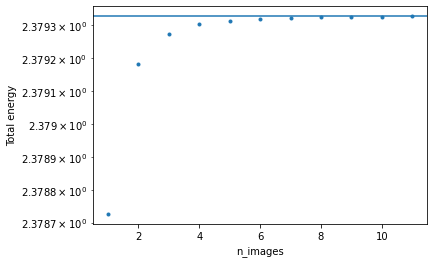

In [19]:
relerr = (cubic_energy[-1] - cubic_energy[-2])/cubic_energy[-1]
print('Relative error at final point: ', relerr)
plt.yscale("log")
plt.plot(1+np.arange(len(cubic_energy)),
         cubic_energy, ".")
plt.axhline(cubic_energy[-1])
plt.xlabel("n_images")
plt.ylabel("Total energy");

# Compare the features with the explicit implementations

In [20]:
# Define inputs
smearing = 1.0
p = 6
f_real = lambda x: density_realspace(p, x, smearing)
f_fourier = lambda k: density_fourierspace(p, k, smearing)
f_ref = lambda x: 1/x**p

# Compensate for the lack of the center atom contribution
f0_real = 1 / (2*smearing**2)**(p/2) / gamma(p/2+1)
peff = 3-p
prefac = np.pi**1.5 * 2**peff / gamma(p/2) # global prefactor appearing in Fourier transformed density
f0_fourier = prefac * 2**((p-1)/2) / (-peff) * smearing**(-peff)
Ls = np.geomspace(0.3, 6, 30)

### Version 1: With center contribution (matching the previously computed lattice sums)

In [ ]:
# Get the reference energies
positions = np.array([[0, 0, 0]])
nneigh = 16
Ls = np.geomspace(0.5, 12, 50)
Ls_fourier = 2 * np.pi / Ls

# Evaluate the lattice sums using both methods
potential_real = np.zeros_like(Ls)
potential_fourier = np.zeros_like(Ls)
potential_ref = np.zeros_like(Ls)
for iL, L in enumerate(Ls):
    box = [L, L, L, 90, 90, 90]
    L_k = Ls_fourier[iL]
    box_fourier = [L_k, L_k, L_k, 90, 90, 90]
    potential_ref[iL] = periodic_energy(positions=positions,
                                   interaction_func=f_ref,
                                   box=box,
                                   nneigh=nneigh)
    potential_real[iL] = periodic_energy(positions=positions,
                                   interaction_func=f_real,
                                   box=box,
                                   nneigh=nneigh)
    potential_fourier[iL] = periodic_energy(positions=positions,
                                   interaction_func=f_fourier,
                                   box=box_fourier,
                                   nneigh=nneigh) / L**3

potential_real += f0_real
potential_fourier += f0_fourier / Ls**3

In [ ]:
frames = []
pos = [[0,0,0]]
Ls_large = Ls[Ls >= 2*smearing]
for iL, L in enumerate(Ls_large):
    # Add cell to structures
    cell = np.eye(3)*L
    frame = Atoms('Si', positions=pos, cell=cell, pbc=True)
    frames.append(frame)

In [ ]:
nmax = 1
lmax = 0
rcut = 0.1

hypers = {
    'smearing':smearing,
    'max_angular':lmax,
    'max_radial':nmax,
    'cutoff_radius':rcut,
    'potential_exponent':p,
    'radial_basis': 'monomial',
    'compute_gradients':False,
    'subtract_center_contribution':False,
    'fast_implementation':True
}

calculator_pylode = DensityProjectionCalculator(**hypers)

In [ ]:
calculator_pylode.transform(frames)
features_pylode = calculator_pylode.features
prefac_e = np.sqrt(3 / (4 * np.pi * rcut**3))
potential_pylode = prefac_e * features_pylode.flatten()

In [ ]:
fig, ax = plt.subplots(figsize=(11,3.5), ncols = 3)
ax[0].scatter(Ls, potential_real, c='cyan', marker='o', label='Real space sum')
ax[0].scatter(Ls, potential_fourier, c='r', marker='+', label='Fourier space sum')
ax[0].scatter(Ls_large, potential_pylode, c='g', marker='s', label='PyLODE')
ax[0].legend(loc='upper right')
ax[0].set_yscale('log')
ax[0].set_title('Lattice sums vs pyLODE')
ax[0].axhline(y = f0_real, color = 'k', linestyle = '--')
ax[0].set_xscale('log')
ax[0].set_xlabel('Box size L')
ax[0].set_ylabel('Potentials')

ratios = potential_fourier / potential_real
ratios_pylode = potential_pylode / potential_fourier[-len(Ls_large):]
ax[1].scatter(Ls, ratios, c='r', marker='+', label='Fourier / Real')
ax[1].scatter(Ls_large, ratios_pylode, c='g', marker='s', label='pyLODE / Fourier')
ax[1].set_title('Ratio between methods')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(loc='upper right')
ax[1].set_xlabel('Box size L')

ax[2].semilogy(Ls, np.abs(ratios - 1.), 'bo')
ax[2].set_title('Relative difference')
ax[2].set_xlabel('Box size L')

### Repeat for version without center contribution

In [ ]:
hypers_without_center = {
    'smearing':smearing,
    'max_angular':lmax,
    'max_radial':nmax,
    'cutoff_radius':rcut,
    'potential_exponent':p,
    'radial_basis': 'monomial',
    'compute_gradients':False,
    'subtract_center_contribution':True,
    'fast_implementation':True
}

calculator_pylode_without_center = DensityProjectionCalculator(**hypers_without_center)

In [ ]:
calculator_pylode_without_center.transform(frames)
features_pylode_without_center = calculator_pylode_without_center.features
potential_pylode_without_center = prefac_e * features_pylode_without_center.flatten()

In [ ]:
fig, ax = plt.subplots(figsize=(11,3.5), ncols = 3)
ax[0].scatter(Ls, potential_real - f0_real, c='cyan', marker='o', label='Real space sum')
ax[0].scatter(Ls, potential_fourier - f0_real, c='r', marker='+', label='Fourier space sum')
ax[0].scatter(Ls_large, potential_pylode_without_center, c='g', marker='s', label='PyLODE')
ax[0].legend(loc='upper right')
ax[0].set_yscale('log')
ax[0].set_title('Lattice sums vs pyLODE')
ax[0].axhline(y = f0_real, color = 'k', linestyle = '--')
ax[0].set_xscale('log')
ax[0].set_xlabel('Box size L')
ax[0].set_ylabel('Potentials')

ratios_without_center = (potential_fourier - f0_real) / (potential_real - f0_real)
ratios_pylode_without_center = potential_pylode_without_center / (potential_fourier[-len(Ls_large):] - f0_real)
ax[1].scatter(Ls, ratios_without_center, c='r', marker='+', label='Fourier / Real')
ax[1].scatter(Ls_large, ratios_pylode_without_center, c='g', marker='s', label='pyLODE / Fourier')
ax[1].set_title('Ratio between methods')
ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].legend(loc='upper right')
ax[1].set_xlabel('Box size L')
ax[1].set_ylabel('Ratio of potential')

ax[2].semilogy(Ls, np.abs(ratios_without_center - 1.), 'bo')
ax[2].set_title('Relative difference')